In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns

from matplotlib import rcParams
from sklearn.linear_model import LinearRegression

LoadDatas
-----
- excel data structure
    - column.row
    - col.0 : B1
    - col.1 : B1_1_동
    - col.2 : B1_1_호수
    - col.3:end : timeslot

In [2]:
xlsx = pd.read_excel('datas.xlsx', 
                    header = None, 
                    skiprows = 2,
                    engine = 'openpyxl')

data_startcol = 7
ogDatasObj = {}
for col in xlsx:
    if col >= data_startcol: # startcol 7
        ogDatasObj[f'{xlsx[col][0]}-{xlsx[col][1]}-{xlsx[col][2]}'] = xlsx[col][3:]

ogDatas = pd.DataFrame(ogDatasObj)
ogDatas = ogDatas.fillna(0)
ogDatas = ogDatas.reset_index()
del ogDatas['index']

pd.set_option('display.max_row', 20)
pd.set_option('display.max_columns', 100)

ogDatas

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,아파트1-103-502,아파트1-103-1602,아파트1-103-301,아파트1-103-1502,아파트1-103-202,아파트1-102-903,아파트1-102-603,아파트1-102-203,아파트1-102-704,아파트1-102-703,아파트1-102-403,아파트1-102-303,아파트1-101-604,아파트1-101-1602,아파트1-101-1002,아파트1-101-1202,아파트1-101-1604,아파트1-101-402,아파트1-101-303,아파트1-101-502,아파트1-101-1403,아파트1-101-904,아파트1-101-1502,아파트1-101-1102,아파트1-101-901,아파트1-101-704,아파트1-101-504,아파트1-102-104,아파트1-102-301,아파트1-102-1501,아파트1-102-1602,아파트1-102-1002,아파트1-102-401,아파트1-102-802,아파트1-102-801,아파트1-103-505,아파트1-103-1805,아파트1-103-1306,아파트1-103-1806,아파트1-103-803,...,아파트4-103-609,아파트4-103-707,아파트4-103-101,아파트4-102-803,아파트4-101-1501,아파트4-103-404,아파트4-103-909,아파트4-101-1203,아파트4-103-806,아파트4-103-1410,아파트4-103-402,아파트4-103-703,아파트4-103-106,아파트4-103-910,아파트4-102-402,아파트4-103-907,아파트4-103-1406,아파트4-103-1006,아파트4-103-608,아파트4-103-403,아파트4-105-1102,아파트4-103-804,아파트4-103-103,아파트4-103-706,아파트4-104-1001,아파트4-105-103,아파트4-102-401,아파트4-103-1104,아파트4-103-906,아파트4-103-606,아파트4-103-1307,아파트4-103-410,아파트4-103-1309,아파트4-102-102,아파트4-103-508,아파트4-105-1104,아파트4-102-1402,아파트4-103-407,아파트4-103-1206,아파트4-103-108,아파트4-105-102,아파트4-103-1102,아파트4-105-601,아파트4-104-1501,아파트4-103-702,아파트4-102-104,아파트4-103-902,아파트4-101-602,아파트4-103-905,아파트4-101-104
0,0.085,0.016,0.052,0.003,0.032,0.074,0.053,0.096,0.105,0.042,0.149,0.039,0.054,0.132,0.091,0.169,0.051,0.118,0.060,0.047,0.047,0.053,0.046,0.104,0.079,0.092,0.043,0.069,0.139,0.026,0.146,0.092,0.025,0.127,0.045,0.042,0.113,0.207,0.030,0.171,0.045,0.064,0.045,0.277,0.186,0.142,0.132,0.034,0.088,0.041,...,0.041,0.137,0.114,0.046,0.098,0.058,0.068,0.040,0.063,0.048,0.168,0.053,0.099,0.075,0.080,0.158,0.024,0.153,0.056,0.037,0.091,0.069,0.128,0.092,0.072,0.069,0.034,0.166,0.086,0.113,0.184,0.175,0.096,0.054,0.080,0.084,0.119,0.088,0.117,0.161,0.182,0.044,0.051,0.057,0.126,0.094,0.065,0.116,0.093,0.147
1,0.086,0.049,0.053,0.002,0.022,0.014,0.048,0.090,0.108,0.022,0.119,0.023,0.075,0.142,0.063,0.183,0.045,0.164,0.065,0.066,0.043,0.056,0.045,0.130,0.081,0.102,0.042,0.083,0.176,0.046,0.113,0.088,0.026,0.116,0.066,0.050,0.139,0.188,0.031,0.165,0.032,0.068,0.052,0.244,0.209,0.205,0.161,0.039,0.094,0.036,...,0.036,0.083,0.124,0.055,0.115,0.068,0.072,0.032,0.085,0.111,0.173,0.050,0.103,0.068,0.076,0.360,0.031,0.132,0.038,0.037,0.097,0.075,0.123,0.072,0.053,0.059,0.023,0.135,0.143,0.112,0.101,0.163,0.154,0.078,0.036,0.076,0.092,0.042,0.121,0.179,0.117,0.060,0.036,0.055,0.116,0.089,0.083,0.113,0.105,0.130
2,0.085,0.013,0.073,0.002,0.016,0.051,0.029,0.033,0.097,0.046,0.116,0.018,0.071,0.096,0.159,0.122,0.043,0.141,0.097,0.064,0.055,0.054,0.051,0.119,0.109,0.097,0.056,0.086,0.126,0.036,0.113,0.079,0.027,0.170,0.072,0.044,0.163,0.201,0.053,0.163,0.041,0.071,0.046,0.256,0.173,0.199,0.122,0.028,0.084,0.026,...,0.045,0.081,0.115,0.063,0.070,0.053,0.078,0.036,0.083,0.111,0.084,0.053,0.084,0.071,0.087,0.471,0.024,0.079,0.047,0.036,0.078,0.059,0.137,0.084,0.083,0.056,0.036,0.106,0.160,0.108,0.184,0.162,0.124,0.135,0.053,0.073,0.108,0.056,0.100,0.224,0.147,0.053,0.075,0.032,0.131,0.055,0.084,0.153,0.119,0.104
3,0.085,0.043,0.067,0.002,0.015,0.015,0.031,0.092,0.048,0.067,0.102,0.031,0.128,0.082,0.104,0.141,0.031,0.103,0.075,0.082,0.046,0.016,0.046,0.078,0.070,0.073,0.051,0.085,0.098,0.048,0.145,0.078,0.021,0.142,0.062,0.034,0.149,0.194,0.038,0.065,0.043,0.070,0.043,0.274,0.047,0.108,0.162,0.034,0.069,0.038,...,0.039,0.086,0.068,0.035,0.064,0.061,0.065,0.022,0.066,0.087,0.080,0.047,0.079,0.066,0.029,0.187,0.030,0.059,0.055,0.035,0.080,0.074,0.090,0.066,0.071,0.062,0.034,0.114,0.121,0.108,0.051,0.170,0.068,0.072,0.074,0.078,0.101,0.080,0.084,0.178,0.152,0.047,0.064,0.022,0.104,0.057,0.087,0.149,0.102,0.093
4,0.084,0.033,0.051,0.003,0.022,0.052,0.052,0.030,0.041,0.045,0.102,0.032,0.122,0.069,0.089,0.103,0.011,0.094,0.084,0.053,0.047,0.022,0.048,0.040,0.077,0.089,0.041,0.092,0.062,0.045,0.109,0.109,0.033,0.084,0.069,0.035,0.225,0.199,0.078,

SetDatas
---
## 특정 가구를 날짜별로 나누는 작업
- timeslotDatas === tsDatas

In [3]:
startDate = datetime(2018,5,1)
endDate = datetime(2019,5,1)
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
dateIndexArr = [dt.strftime('%Y%m%d') for dt in
                   datetime_range(startDate, endDate, timedelta(days = 1))]

searchKeyword = '아파트1-104-1206'
tsDatasObj = {}
startIdx = 0;
endIdx = 96;
for date in dateIndexArr:
    tsDatasObj[date] = ogDatas[searchKeyword][startIdx:endIdx].values.tolist()
    startIdx = endIdx
    endIdx = endIdx + 96

tsDatas = pd.DataFrame(tsDatasObj)
tsDatas = tsDatas.T
tsDatas = tsDatas.reset_index()
tsDatas.rename(columns={'index':'date'}, inplace=True)
tsDatas['year'] = [dt[0:4] for dt in tsDatas['date']]
tsDatas['month'] = [dt[4:6] for dt in tsDatas['date']]
tsDatas['day'] = [dt[6:8] for dt in tsDatas['date']]
tsDatas['date'] = [datetime.strptime(dt, "%Y%m%d") for dt in tsDatas['date']]
tsDatas.reindex(columns=['date', 'year', 'month', 'day'])

,date,year,month,day
0,2018-05-01,2018,05,01
1,2018-05-02,2018,05,02
2,2018-05-03,2018,05,03
3,2018-05-04,2018,05,04
4,2018-05-05,2018,05,05
...,...,...,...,...
360,2019-04-26,2019,04,26
361,2019-04-27,2019,04,27
362,2019-04-28,2019,04,28
363,2019-04-29,2019,04,29


Select Season, Day
---
## 해당 가구의 데이터 중에서 계절, 날짜에 맞게 변환

In [4]:
DAYS = {
    "월" : 0,
    "화" : 1,
    "수" : 2,
    "목" : 3,
    "금" : 4,
    "토" : 5,
    "일" : 6
}

SEASONS = {
    "봄" : ["03", "04", "05"],
    "여름" : ["06", "07", "08"],
    "가을" : ["09", "10", "11"],
    "겨울" : ["12", "01", "02"]
}

ALLDATAS = False
DAY = "월"
SEASON = "봄"
# ALLDATAS is tsDatas
if ALLDATAS:
    datas = tsDatas
else :    
    datas = tsDatas[(tsDatas['month'].isin(SEASONS[SEASON]))
            & (tsDatas['date'].dt.weekday == DAYS[DAY]) ]
datas

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,year,month,day
6,2018-05-07,0.100,0.117,0.078,0.052,0.051,0.032,0.044,0.051,0.050,0.043,0.030,0.050,0.051,0.050,0.034,0.041,0.051,0.050,0.047,0.030,0.046,0.050,0.050,0.036,0.036,0.051,0.050,0.043,0.030,0.053,0.056,0.093,0.052,0.058,0.056,0.055,0.055,0.054,0.054,0.054,0.053,0.053,0.053,0.054,0.053,0.053,0.052,0.054,0.053,0.053,0.052,0.053,0.046,0.032,0.054,0.052,0.053,0.052,0.032,0.046,0.053,0.053,0.052,0.034,0.045,0.054,0.052,0.052,0.033,0.047,0.054,0.053,0.053,0.034,0.046,0.053,0.053,0.052,0.039,0.040,0.053,0.053,0.052,0.041,0.076,0.119,0.084,0.084,0.070,0.071,0.086,0.090,0.090,0.084,0.081,0.088,2018,05,07
13,2018-05-14,0.113,0.076,0.056,0.059,0.059,0.047,0.055,0.057,0.056,0.054,0.054,0.054,0.054,0.053,0.053,0.053,0.053,0.052,0.053,0.052,0.052,0.054,0.052,0.052,0.052,0.051,0.052,0.051,0.051,0.051,0.058,0.092,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.050,0.043,0.030,0.049,0.051,0.050,0.043,0.029,0.049,0.051,0.051,0.038,0.032,0.050,0.050,0.048,0.030,0.044,0.051,0.050,0.037,0.034,0.056,0.056,0.053,0.043,0.054,0.053,0.052,0.052,0.052,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.118,0.089,0.064,0.062,0.061,0.060,0.059,0.057,0.054,0.053,0.050,0.050,0.050,0.046,0.029,0.046,0.050,0.050,0.041,2018,05,14
20,2018-05-21,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.056,0.055,0.056,0.056,0.055,0.054,0.055,0.055,0.054,0.055,0.055,0.055,0.054,0.051,0.035,0.055,0.055,0.055,0.053,0.040,0.043,0.055,0.054,0.055,0.046,0.037,0.055,0.055,0.055,0.038,0.045,0.062,0.087,0.133,0.070,0.073,0.086,0.084,0.080,0.063,0.082,0.085,0.084,2018,05,21
27,2018-05-28,0.054,0.054,0.054,0.054,0.054,0.080,0.067,0.053,0.055,0.054,0.055,0.054,0.054,0.053,0.053,0.043,0.039,0.053,0.054,0.053,0.052,0.033,0.048,0.054,0.053,0.053,0.036,0.044,0.054,0.053,0.053,0.076,0.043,0.050,0.051,0.050,0.031,0.045,0.050,0.050,0.051,0.032,0.044,0.051,0.050,0.050,0.043,0.033,0.051,0.052,0.058,0.056,0.043,0.053,0.054,0.052,0.052,0.051,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.050,0.051,0.050,0.050,0.051,0.050,0.050,0.050,0.050,0.051,0.084,0.097,0.093,0.096,0.071,0.062,0.061,0.052,0.041,0.058,2018,05,28
307,2019-03-04,0.029,0.021,0.021,0.021,0.035,0.037,0.021,0.020,0.021,0.028,0.037,0.028,0.020,0.022,0.020,0.037,0.034,0.021,0.021,0.021,0.028,0.038,0.025,0.021,0.051,0.033,0.037,0.033,0.021,0.021,0.021,0.029,0.037,0.025,0.021,0.021,0.021,0.038,0.032,0.021,0.021,0.021,0.030,0.037,0.024,0.021,0.021,0.021,0.038,0.031,0.021,0.021,0.020,0.032,0.037,0.024,0.021,0.021,0.021,0.040,0.031,0.021,0.021,0.021,0.031,0.037,0.023,0.021,0.021,0.024,0.038,0.030,0.021,0.021,0.022,0.032,0.038,0.021,0.021,0.028,0.076,0.092,0.081,0.075,0.062,0.061,0.072,0.076,0.061,0.060,0.061,0.065,0.073,0.029,0.022,0.022,2019,03,04
314,2019-03-11,0.013,0.013,0.013,0.029,0.037,0.016,0.012,0.013,0.026,0.031,0.023,0.013,0.012,0.021,0.028,0.029,0.016,0.021,0.012,0.018,0.030,0.030,0.016,0.013,0.033,0.037,0.029,0.018,0.013,0.013,0.013,0.031,0.027,0.013,0.012,0.013,0.021,0.029,0.021,0.013,0.013,0.012,0.028,0.029,0.014,0.013,0.013,0.016,0.030,0.024,0.013,0.012,0.013,0.023,0.029,0.018,0.012,0.013,0.013,0.028,0.028,0.013,0.013,0.012,0.017,0.030,0.022,0.013,0.012,0.013,0.022,0.029,0.017,0.013,0.013,0.012,0.026,0.029,0.026,0.064,0.053,0.048,0.064,0.062,0.056,0.046,0.046,0.052,0.070,0.061,0.036,0.013,0.016,0.025,0.029,0.020,2019,03,11
321,2019-03-18,0.050,0.041,0.040,0.009,0.041,0.043,0.027,0.026,0.026,0.033,0.025,0.019,0.007,0

DataPreprocessing
---
- 데이터 전처리
    - StandardScaler : 각 특성의 평균을 0, 분산을 1로 변경하여 특성의
        스케일을 맞춘다.

In [5]:
dpp = datas[datas.columns.difference(['date', 'year', 'month', 'day'])]
dpp = dpp

# Scaler 선택
# STD, MIN, MAX, ROBUST
selScaler = "ROBUST"

scaler = StandardScaler()
if selScaler == "STD":
    scaler = StandardScaler()
elif selScaler == "MIN":
    scaler = MinMaxScaler()
elif selScaler == "MAX":
    scaler = MaxAbsScaler()
elif selScaler == "ROBUST":
    scaler = RobustScaler()

dpp = pd.DataFrame(scaler.fit_transform(dpp))

dpp.index = datas['date']
dpp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-07,1.918919,2.648649,1.500000,0.696970,0.592593,0.000000,0.71875,0.885714,0.896552,0.60,0.0000,0.594595,0.945946,0.896552,0.722222,0.48,0.782609,0.645161,0.81250,0.642857,0.96875,1.238095,0.84,0.466667,0.303030,0.545455,1.000000,0.730769,-0.090909,0.710526,0.945946,2.054054,1.035714,0.972222,0.615385,0.939394,2.266667,1.033333,0.971429,0.837838,0.700000,3.444444,1.071429,0.950,1.027778,1.000000,1.277778,2.384615,0.944444,0.973684,1.44,1.500000,0.695652,0.600000,1.090909,2.266667,1.137931,0.552632,0.411765,0.84,2.000000,0.973684,0.885714,0.117647,0.807692,0.857143,1.000000,1.55,0.523810,0.558824,0.939394,0.828571,1.333333,0.481481,0.315789,0.769231,0.400000,0.076923,-0.458333,-0.526316,0.000000,0.000000,-0.08,-0.750000,1.750,3.7500,0.526316,1.000000,0.130435,0.000000,0.500000,0.756757,2.000000,1.06250,1.032258,1.631579
2018-05-14,2.270270,1.540541,0.888889,0.909091,0.888889,0.555556,1.06250,1.057143,1.103448,1.15,1.5000,0.702703,1.027027,1.000000,1.777778,0.96,0.869565,0.709677,1.00000,2.214286,1.15625,1.428571,0.92,1.533333,0.787879,0.545455,1.095238,1.038462,0.863636,0.657895,1.000000,2.027027,1.000000,0.777778,0.487179,0.818182,2.000000,0.900000,0.885714,0.729730,0.366667,0.888889,0.928571,0.875,0.944444,0.666667,0.000000,2.000000,0.888889,0.921053,0.88,0.333333,0.869565,1.800000,0.909091,0.800000,0.827586,0.526316,1.470588,0.48,0.944444,1.052632,1.000000,1.235294,0.730769,0.857143,1.028571,1.55,1.428571,0.705882,0.848485,0.742857,1.250000,1.074074,0.447368,0.653846,0.266667,5.153846,1.625000,0.736842,0.818182,0.444444,0.24,0.000000,-0.625,-0.3125,-0.289474,-0.214286,-0.739130,-0.807692,-0.833333,-0.891892,-0.588235,0.00000,0.032258,0.394737
2018-05-21,0.621622,0.891892,0.777778,0.696970,0.629630,0.740741,0.96875,0.914286,0.965517,1.05,1.3750,0.648649,0.972973,0.965517,1.722222,0.92,0.826087,0.709677,0.96875,2.214286,1.15625,1.333333,0.92,1.533333,0.787879,0.575758,1.095238,1.076923,0.909091,0.684211,0.837838,0.945946,1.035714,0.805556,0.512821,0.848485,2.066667,0.966667,0.914286,0.783784,0.666667,3.333333,1.035714,0.900,1.000000,0.966667,1.277778,2.230769,0.916667,0.947368,1.44,1.444444,0.956522,2.200000,1.121212,2.533333,1.241379,0.631579,1.705882,1.20,2.111111,1.000000,0.971429,1.352941,1.192308,0.857143,0.971429,0.70,1.571429,0.794118,0.969697,0.828571,0.791667,0.814815,0.552632,0.807692,0.533333,-0.384615,-0.541667,0.263158,0.181818,0.111111,-0.64,-0.583333,0.000,1.7500,1.815789,0.500000,0.260870,0.576923,0.433333,0.486486,0.411765,1.00000,1.161290,1.526316
2018-05-28,0.675676,0.945946,0.833333,0.757576,0.703704,1.777778,1.43750,0.942857,1.068966,1.15,1.5625,0.702703,1.027027,1.000000,1.777778,0.56,0.260870,0.741935,1.03125,2.285714,1.15625,0.428571,0.76,1.666667,0.818182,0.606061,0.333333,0.769231,1.000000,0.710526,0.864865,1.594595,0.714286,0.750000,0.487179,0.787879,0.666667,0.733333,0.857143,0.729730,0.633333,1.111111,0.750000,0.875,0.944444,0.900000,0.777778,0.769231,0.888889,0.947368,1.68,1.666667,0.565217,2.000000,1.090909,2.266667,1.103448,0.526316,1.529412,1.04,1.888889,0.921053,0.857143,1.058824,1.038462,0.771429,0.942857,1.50,1.380952,0.647059,0.848485,0.771429,1.208333,1.111111,0.447368,0.653846,0.200000,0.000000,0.000000,0.000000,-0.181818,-0.166667,-0.16,-0.375000,-1.500,-0.5000,0.526316,1.464286,1.130435,0.961538,0.000000,0.000000,0.294118,0.06250,-0.258065,0.842105
2019-03-04,0.000000,0.054054,-0.083333,-0.242424,0.000000,0.185185,0.00000,0.000000,-0.103448,-0.15,0.4375,0.000000,0.108108,-0.068966,-0.055556,0.32,0.043478,-0.290323,0.00000,0.000000,0.40625,0.666667,-0.16,-0.533333,0.757576,0.000000,0.380952,0.346154,-0.50000

Dimensionality Reduction
---
- 차원축소
    - PCA : Principal component analysis, 주성분 분석

In [6]:
pca = PCA(n_components=2)

pca.fit(dpp)
dr = pd.DataFrame(pca.transform(dpp), columns = ['x','y'])

dr.index = datas['date']
dr

,x,y
date,,
2018-05-07,11.459121,-0.699216
2018-05-14,11.084191,2.470812
2018-05-21,12.645530,0.007833
2018-05-28,11.223524,0.934446
2019-03-04,-1.231560,-0.164550
2019-03-11,-5.287013,2.301037
2019-03-18,-5.734383,0.711375
2019-03-25,-2.694101,-6.699826
2019-04-01,-8.150084,-2.647204


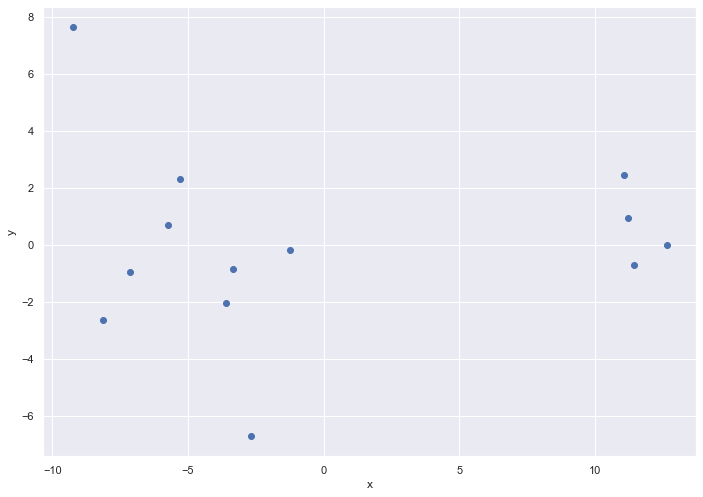

In [15]:
plt.scatter(dr['x'], dr['y'], marker = 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

KMeans Clustering
---

In [8]:
K = 5

points = dr.values
kmeans = KMeans(n_clusters=K).fit(points)
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['x', 'y'])

clusterNum = [i for i in range(K)]
centers['cluster'] = [i for i in range(len(centers))]
centers['type'] = [f'cluster' for dt in clusterNum]
centers

,x,y,cluster,type
0,-6.578245,-0.149798,0,cluster
1,11.603091,0.678469,1,cluster
2,-2.722063,-1.019197,2,cluster
3,-9.239093,7.642732,3,cluster
4,-2.694101,-6.699826,4,cluster


In [9]:
kmeans.labels_

array([1, 1, 1, 1, 2, 0, 0, 4, 0, 2, 2, 3, 0], dtype=int32)

In [10]:
clustering = dr
clustering['cluster'] = kmeans.labels_
clustering['type'] = ['data' for i in range(len(clustering['x']))]

result = pd.concat([clustering, centers], axis = 0)

result

,x,y,cluster,type
2018-05-07 00:00:00,11.459121,-0.699216,1,data
2018-05-14 00:00:00,11.084191,2.470812,1,data
2018-05-21 00:00:00,12.645530,0.007833,1,data
2018-05-28 00:00:00,11.223524,0.934446,1,data
2019-03-04 00:00:00,-1.231560,-0.164550,2,data
2019-03-11 00:00:00,-5.287013,2.301037,0,data
2019-03-18 00:00:00,-5.734383,0.711375,0,data
2019-03-25 00:00:00,-2.694101,-6.699826,4,data
2019-04-01 00:00:00,-8.150084,-2.647204,0,data
2019-04-08 00:00:00,-3.590298,-2.054368,2,data


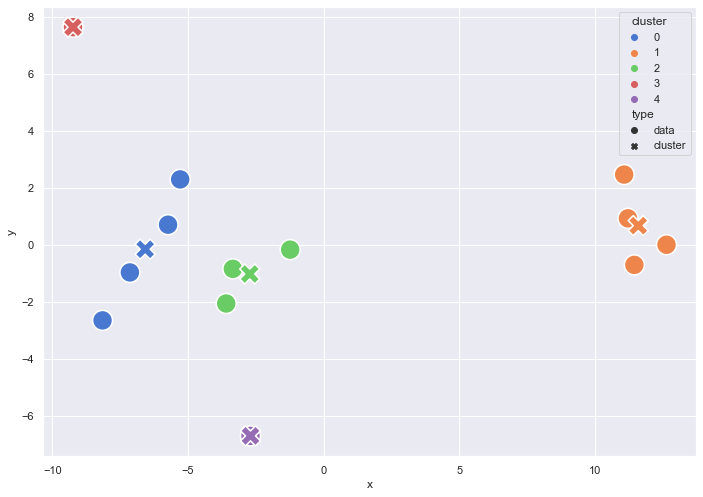

In [14]:
sns.scatterplot(x='x', y="y", 
                hue="cluster", 
                style="type",
                palette="muted",
                s=400,
                data=result)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
rcParams['figure.figsize'] = 11.7,8.27
plt.title = "클러스터링 결과물"
plt.show()

1안 : 일반 적인 그룹핑 데이터
---

<AxesSubplot:>

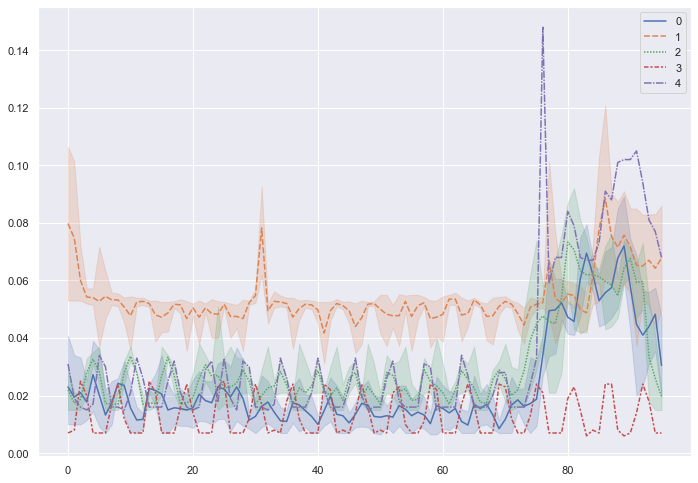

In [12]:
tsCheck = datas[datas.columns.difference(['year', 'month', 'day'])]
tsCheck.reset_index(inplace=True)
del tsCheck['index']
tsCheck = tsCheck.set_index('date')
tsCheck['cluster'] = clustering['cluster']
tsCheck.reset_index(inplace=True)
tsCheck.set_index(['cluster', 'date'], inplace=True)
tsCheck = tsCheck.T
tsCheck
sns.lineplot(data=tsCheck)

2안 : 데이터 전처리 데이터
---

<AxesSubplot:>

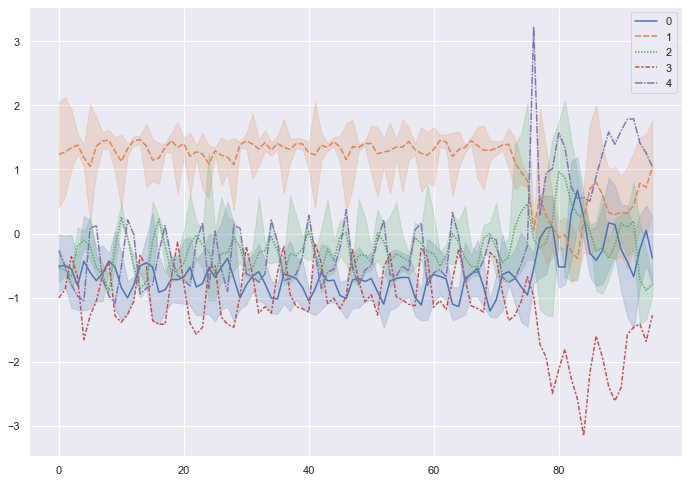

In [13]:
dppCheck = dpp
dppCheck['cluster'] = clustering['cluster']
dppCheck.reset_index(inplace=True)
dppCheck.set_index(['cluster', 'date'], inplace=True)
dppCheck = dppCheck.T
dppCheck
sns.lineplot(data=dppCheck)

3안 : 데이터 군집이 잘 이루어졌는지 확인하기
---

In [16]:
'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
processingData = [];
for d in tsCheck:
    for idx,t in enumerate(tsCheck[d]):
        processingData.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t
        })
processingData = pd.DataFrame(processingData)
processingData

,date,timeslot,cluster,data
0,2018-05-07,0,cluster-1,0.100
1,2018-05-07,1,cluster-1,0.117
2,2018-05-07,2,cluster-1,0.078
3,2018-05-07,3,cluster-1,0.052
4,2018-05-07,4,cluster-1,0.051
...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.047
1244,2019-04-29,92,cluster-0,0.046
1245,2019-04-29,93,cluster-0,0.049
1246,2019-04-29,94,cluster-0,0.055


<AxesSubplot:xlabel='timeslot', ylabel='data'>

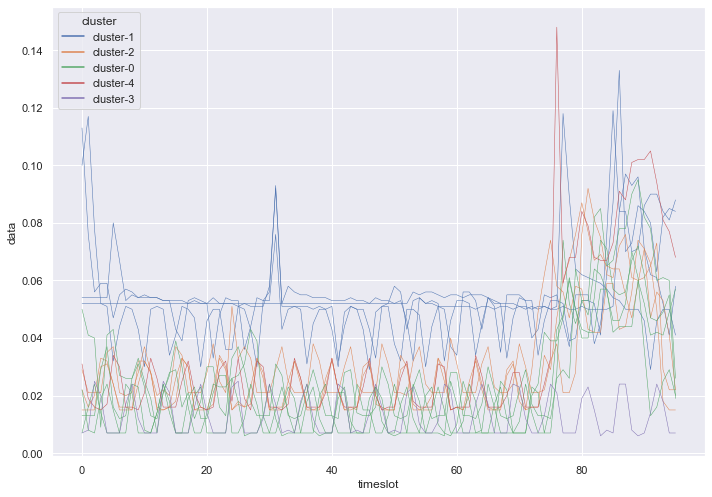

In [17]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            units="date",
            hue="cluster",
            estimator=None,
            lw=0.5)

<AxesSubplot:xlabel='timeslot', ylabel='data'>

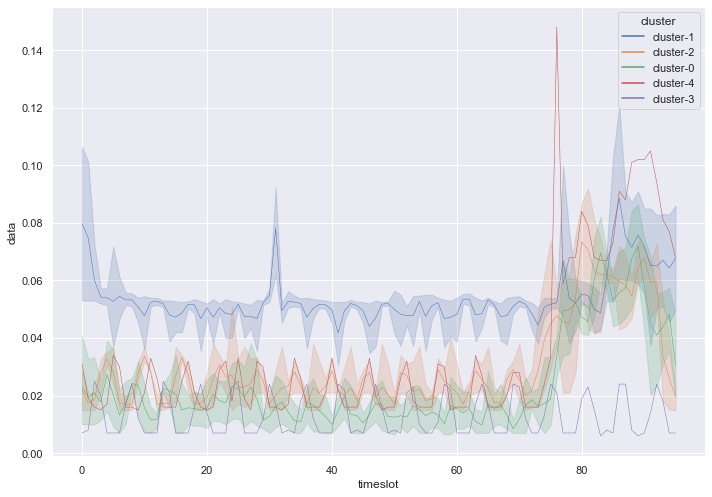

In [18]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            hue="cluster",
            lw=0.5,
            err_style="band") # bars

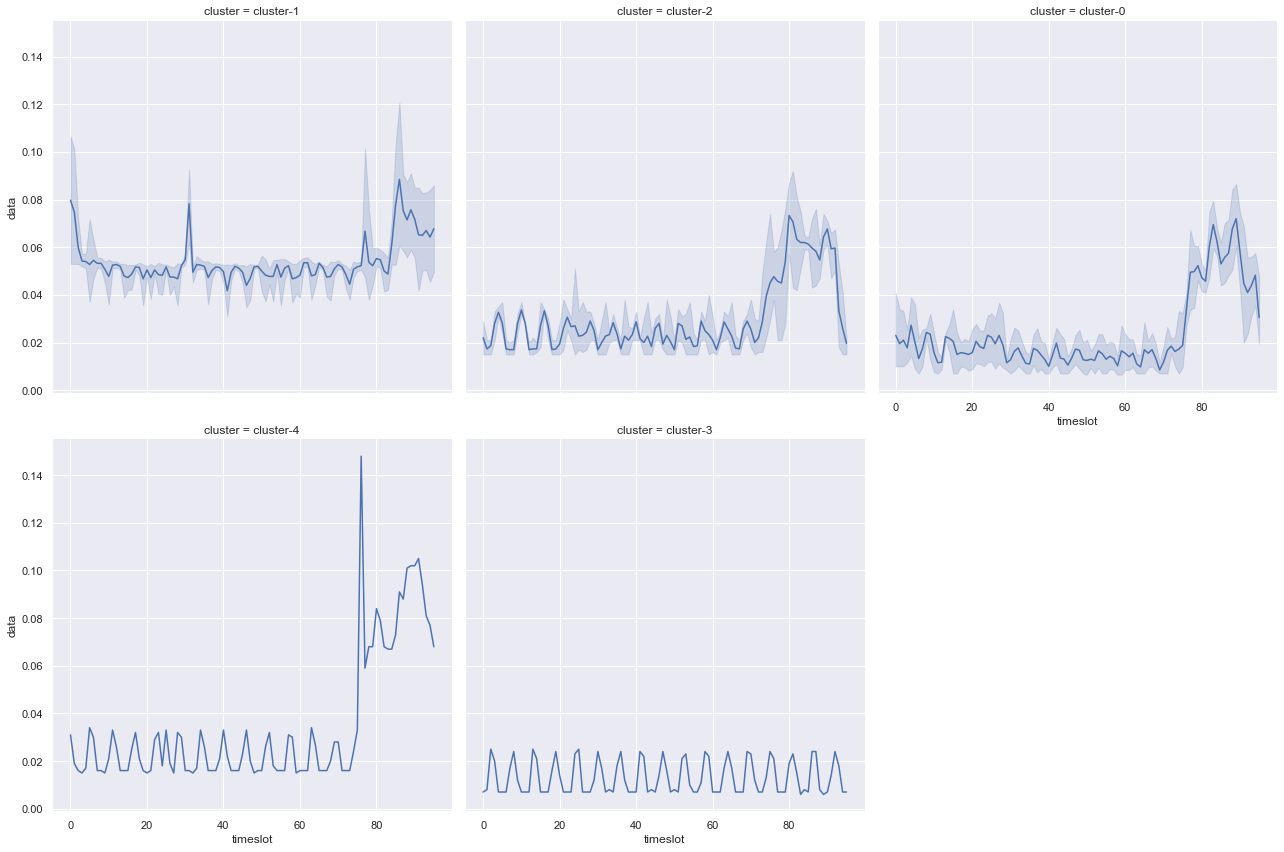

In [19]:
clusterMap = sns.FacetGrid(processingData, col = 'cluster', col_wrap=3, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data")

4안 : Moving Average 가 잘 조화되는지 확인
---

In [20]:
maTest = tsCheck.copy()
maTest

timeslot_3H = maTest.rolling(12).mean()
# timeslot_3H.fillna(0, inplace=True)
timeslot_3H

# sns.lineplot(data=timeslot_3H)

cluster          1                                           2          0  \
date    2018-05-07 2018-05-14 2018-05-21 2018-05-28 2019-03-04 2019-03-11   
0              NaN        NaN        NaN        NaN        NaN        NaN   
1              NaN        NaN        NaN        NaN        NaN        NaN   
2              NaN        NaN        NaN        NaN        NaN        NaN   
3              NaN        NaN        NaN        NaN        NaN        NaN   
4              NaN        NaN        NaN        NaN        NaN        NaN   
..             ...        ...        ...        ...        ...        ...   
91        0.073250   0.052583   0.072333   0.067083   0.070167   0.050583   
92        0.076333   0.051250   0.073000   0.067917   0.069917   0.047500   
93        0.078917   0.050333   0.075250   0.068083   0.064667   0.045583   
94        0.081333   0.049500   0.079167   0.067333   0.059750   0.042667   
95        0.085250   0.048000   0.082417   0.068000   0.055333   0.039167   

cluster                     4          0          2                     3  \
date    2019-03-18 2019-03-25 2019-04-01 2019-04-08 2019-04-15 2019-04-22   
0              NaN        NaN        NaN        NaN        NaN        NaN   
1              NaN        NaN        NaN        NaN        NaN        NaN   
2              NaN        NaN        NaN        NaN        NaN        NaN   
3              NaN        NaN        NaN        NaN        NaN        NaN   
4              NaN        NaN        NaN        NaN        NaN        NaN   
..             ...        ...        ...        ...        ...        ...   
91        0.047333   0.085583   0.075500   0.065917   0.053083   0.013417   
92        0.047250   0.086417   0.076083   0.062833   0.053000   0.013833   
93        0.047167   0.086583   0.076750   0.057917   0.053833   0.013417   
94        0.047750   0.087333   0.074917   0.053583   0.053750   0.012750   
95        0.047750   0.087417   0.070000   0.049083   0.052083   0.012833   

cluster          0  
date    2019-04-29  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
..             ...  
91        0.057917  
92        0.058417  
93        0.059167  
94        0.059250  
95        0.054667  

[96 rows x 13 columns]

In [21]:
'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
ma = [];
for d in timeslot_3H:
    for idx,t in enumerate(timeslot_3H[d]):
        ma.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t
        })
ma = pd.DataFrame(ma)
ma

,date,timeslot,cluster,data
0,2018-05-07,0,cluster-1,NaN
1,2018-05-07,1,cluster-1,NaN
2,2018-05-07,2,cluster-1,NaN
3,2018-05-07,3,cluster-1,NaN
4,2018-05-07,4,cluster-1,NaN
...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.057917
1244,2019-04-29,92,cluster-0,0.058417
1245,2019-04-29,93,cluster-0,0.059167
1246,2019-04-29,94,cluster-0,0.059250


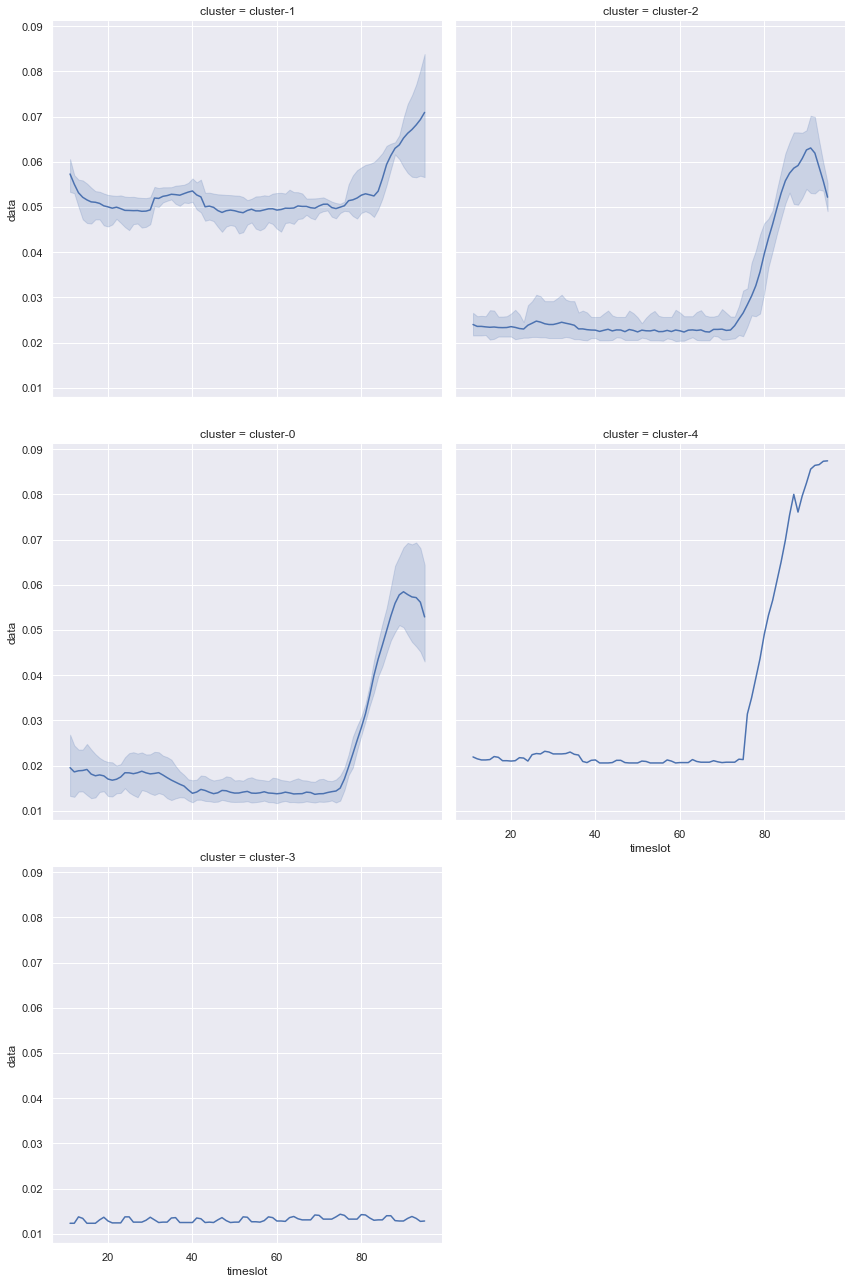

In [22]:
clusterMap = sns.FacetGrid(ma, col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data")

In [23]:
processingData['type'] = 'processingData'
processingData

,date,timeslot,cluster,data,type
0,2018-05-07,0,cluster-1,0.100,processingData
1,2018-05-07,1,cluster-1,0.117,processingData
2,2018-05-07,2,cluster-1,0.078,processingData
3,2018-05-07,3,cluster-1,0.052,processingData
4,2018-05-07,4,cluster-1,0.051,processingData
...,...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.047,processingData
1244,2019-04-29,92,cluster-0,0.046,processingData
1245,2019-04-29,93,cluster-0,0.049,processingData
1246,2019-04-29,94,cluster-0,0.055,processingData


In [24]:
ma['type'] = 'movingaverage'
ma

,date,timeslot,cluster,data,type
0,2018-05-07,0,cluster-1,NaN,movingaverage
1,2018-05-07,1,cluster-1,NaN,movingaverage
2,2018-05-07,2,cluster-1,NaN,movingaverage
3,2018-05-07,3,cluster-1,NaN,movingaverage
4,2018-05-07,4,cluster-1,NaN,movingaverage
...,...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.057917,movingaverage
1244,2019-04-29,92,cluster-0,0.058417,movingaverage
1245,2019-04-29,93,cluster-0,0.059167,movingaverage
1246,2019-04-29,94,cluster-0,0.059250,movingaverage


In [25]:
pdma = pd.concat([processingData, ma], ignore_index=True)
pdma

,date,timeslot,cluster,data,type
0,2018-05-07,0,cluster-1,0.100000,processingData
1,2018-05-07,1,cluster-1,0.117000,processingData
2,2018-05-07,2,cluster-1,0.078000,processingData
3,2018-05-07,3,cluster-1,0.052000,processingData
4,2018-05-07,4,cluster-1,0.051000,processingData
...,...,...,...,...,...
2491,2019-04-29,91,cluster-0,0.057917,movingaverage
2492,2019-04-29,92,cluster-0,0.058417,movingaverage
2493,2019-04-29,93,cluster-0,0.059167,movingaverage
2494,2019-04-29,94,cluster-0,0.059250,movingaverage


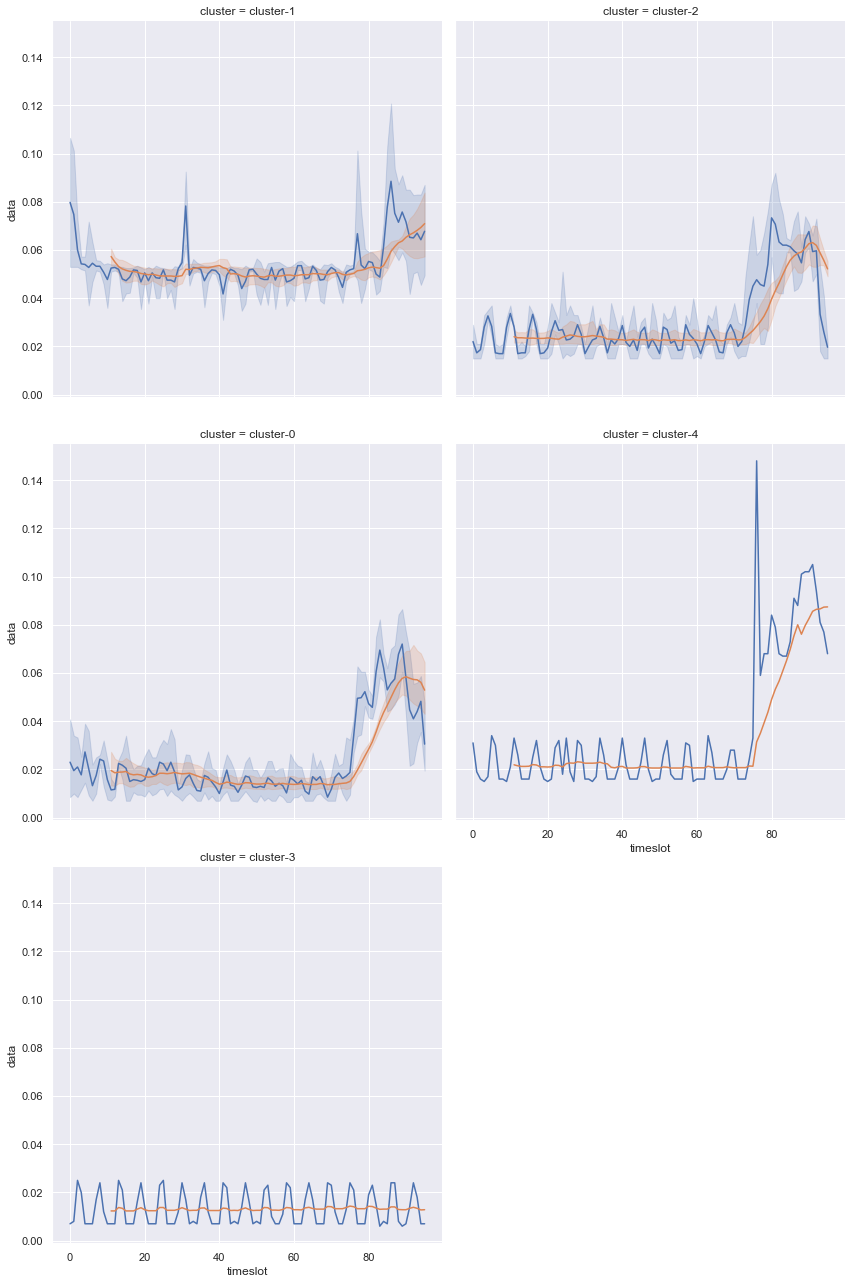

In [26]:
clusterMap = sns.FacetGrid(pdma, col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data", "type")

EMA(Exponential MA)
---

In [27]:
emaTest = tsCheck.copy()
emaTest

timeslot_3H = emaTest.ewm(span=12).mean()
timeslot_3H

'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
ema = [];
for d in timeslot_3H:
    for idx,t in enumerate(timeslot_3H[d]):
        ema.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t,
            "type": "exponential moving average"
        })
ema = pd.DataFrame(ema)
ema

,date,timeslot,cluster,data,type
0,2018-05-07,0,cluster-1,0.100000,exponential moving average
1,2018-05-07,1,cluster-1,0.109208,exponential moving average
2,2018-05-07,2,cluster-1,0.097028,exponential moving average
3,2018-05-07,3,cluster-1,0.082814,exponential moving average
4,2018-05-07,4,cluster-1,0.074170,exponential moving average
...,...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.055965,exponential moving average
1244,2019-04-29,92,cluster-0,0.054432,exponential moving average
1245,2019-04-29,93,cluster-0,0.053596,exponential moving average
1246,2019-04-29,94,cluster-0,0.053812,exponential moving average


In [28]:
pdma = pd.concat([pdma, ema])
pdma

,date,timeslot,cluster,data,type
0,2018-05-07,0,cluster-1,0.100000,processingData
1,2018-05-07,1,cluster-1,0.117000,processingData
2,2018-05-07,2,cluster-1,0.078000,processingData
3,2018-05-07,3,cluster-1,0.052000,processingData
4,2018-05-07,4,cluster-1,0.051000,processingData
...,...,...,...,...,...
1243,2019-04-29,91,cluster-0,0.055965,exponential moving average
1244,2019-04-29,92,cluster-0,0.054432,exponential moving average
1245,2019-04-29,93,cluster-0,0.053596,exponential moving average
1246,2019-04-29,94,cluster-0,0.053812,exponential moving average


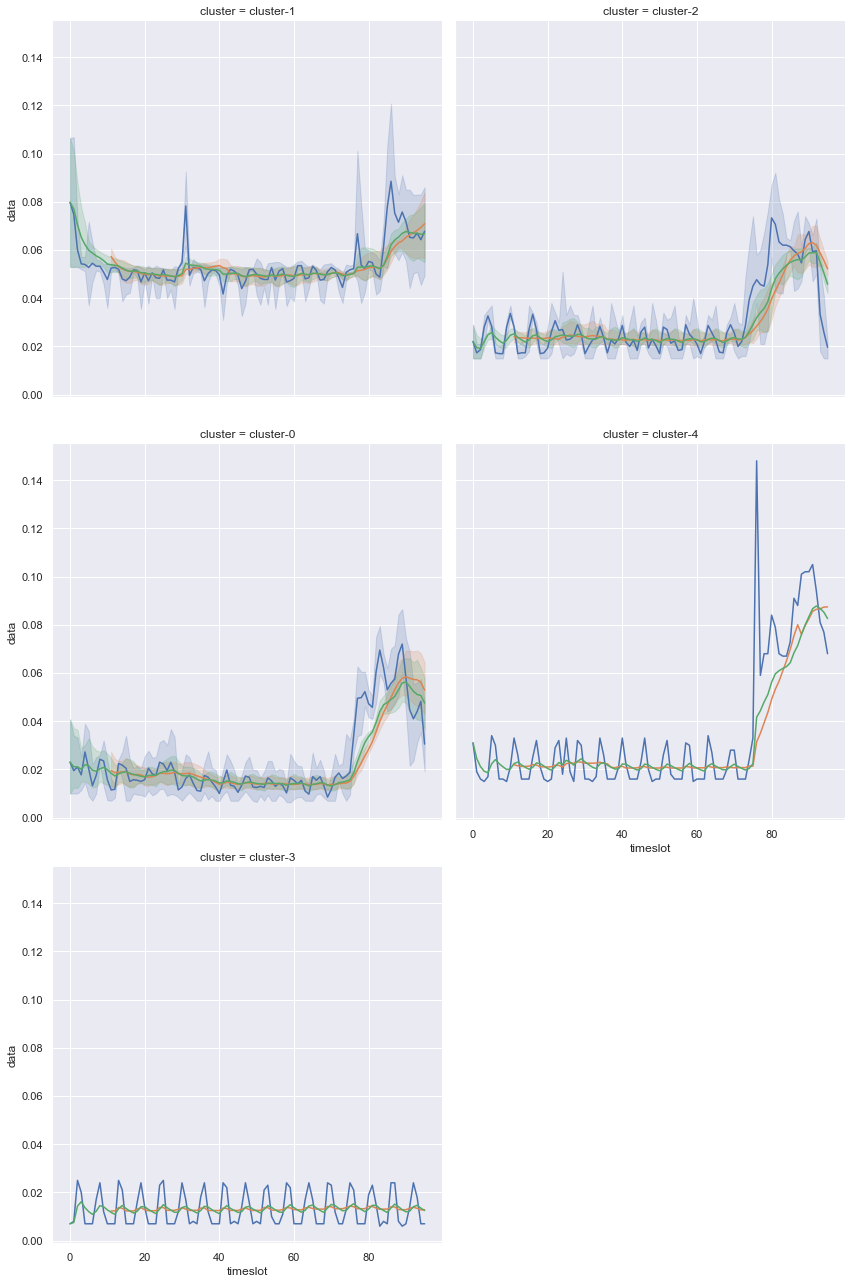

In [33]:
clusterMap = sns.FacetGrid(pdma[(pdma['type'] == 'exponential moving average') 
                               | (pdma['type'] == 'processingData')
                               | (pdma['type'] == 'movingaverage') 
                               ], col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data", "type")